In [ ]:
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

DEVICE        = 'cpu' 
T             = 500        # diffusion steps
BATCH_SIZE    = 512
TRAIN_ITERS   = 2000       # 訓練步數
LR            = 5e-4
HIDDEN        = 512
TIME_DIM      = 64
N_TRAIN_SAMP  = 10000       # 訓練資料量）
### Constants setting
betas = torch.linspace(1e-4, 0.02, T+1, device=DEVICE)
alphas = 1.0-betas
abar = torch.cumprod(alphas, dim=0)
sqrt_abar = torch.sqrt(abar)
sqrt_lmabar = torch.sqrt(1.0-abar)
sqrt_rcp_a = torch.sqrt(1.0 / alphas)


In [ ]:
# 定義兩個 normal distribution
mu1, sigma1 = 0, 1   # N(0, 1)
mu2, sigma2 = 10, 2   # N(10, 2)

n_samples = 10000
weights = [0.5, 0.5]  # mixture ratio

# 先決定每個樣本從哪個分布來
choices = np.random.choice([0, 1], size=n_samples, p=weights)

# 依據 choices 產生樣本
samples = np.where(
    choices == 0,
    np.random.normal(mu1, sigma1, n_samples),
    np.random.normal(mu2, sigma2, n_samples)
)

# 畫圖
plt.hist(samples, bins=50, density=True, alpha=0.6, color='g')
plt.title("Mixture of N(0,1) and N(5,2)")
plt.show()


=== Original x0: A vs B ===
mean: 0.006 vs 5.017
std : 1.004 vs 1.414
KS   : stat=0.9643, p=0.0000
t-test(means): stat=-288.9246, p=0.0000
Levene(vars) : stat=940.8853, p=0.0000


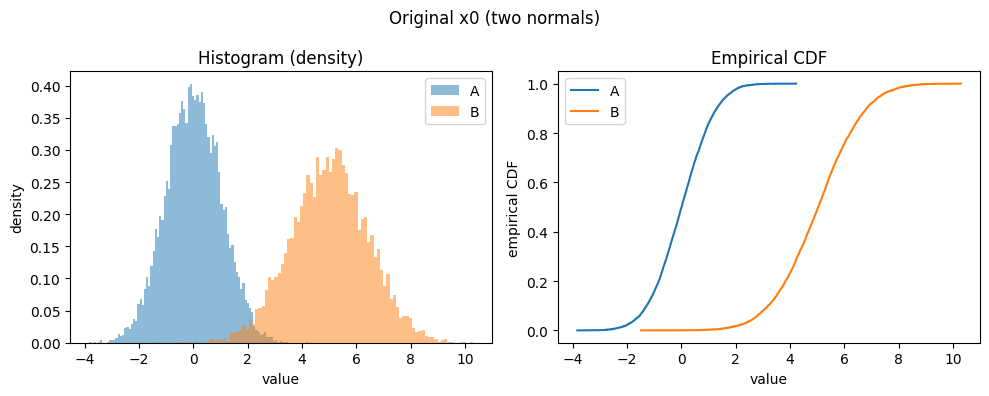


=== Denoise from T: A vs B ===
mean: -0.715 vs 3.977
std : 17.599 vs 17.537
KS   : stat=0.1150, p=0.0000
t-test(means): stat=-18.8882, p=0.0000
Levene(vars) : stat=0.4951, p=0.4817


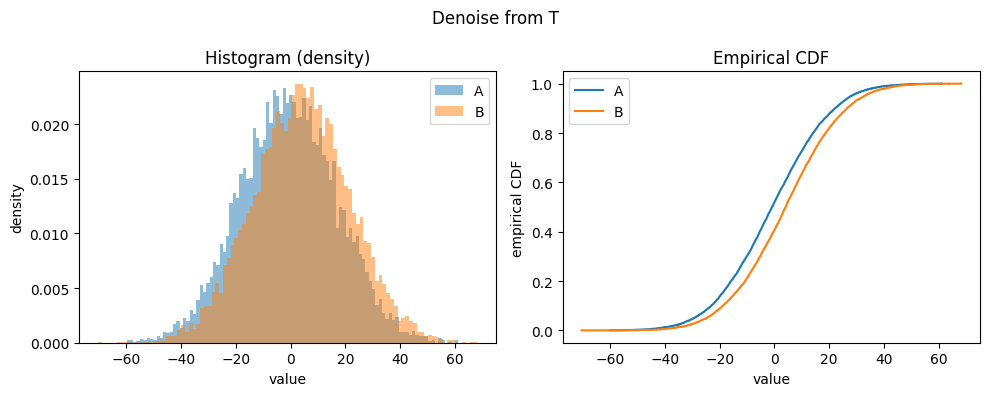

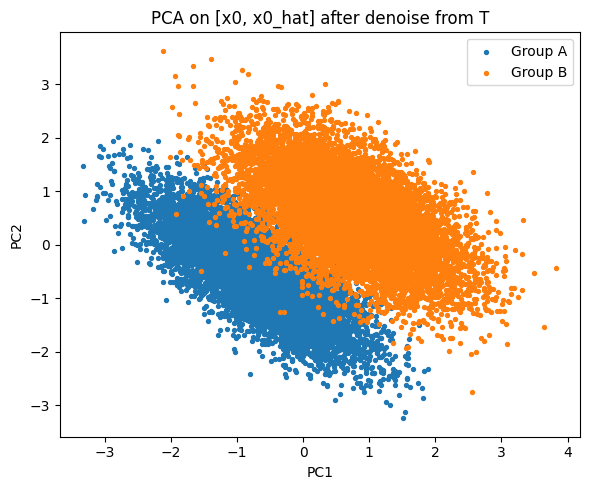


=== Denoise from t=50: A vs B ===
mean: -0.001 vs 4.998
std : 1.061 vs 1.447
KS   : stat=0.9545, p=0.0000
t-test(means): stat=-278.6046, p=0.0000
Levene(vars) : stat=773.4217, p=0.0000


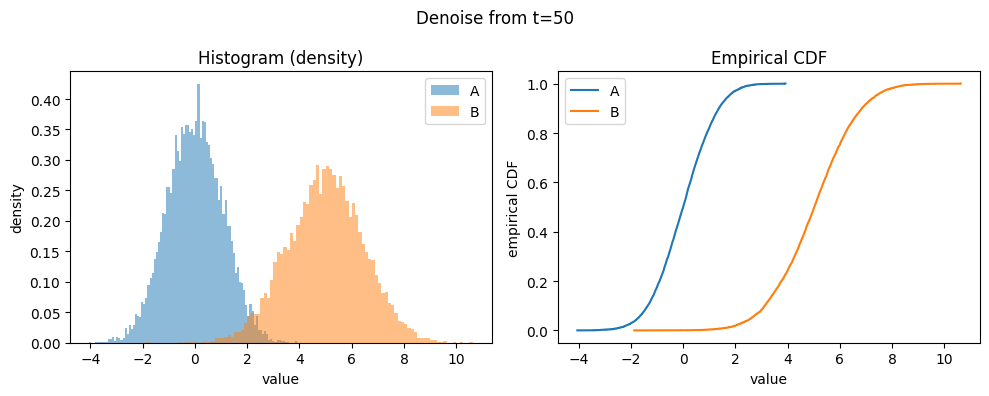

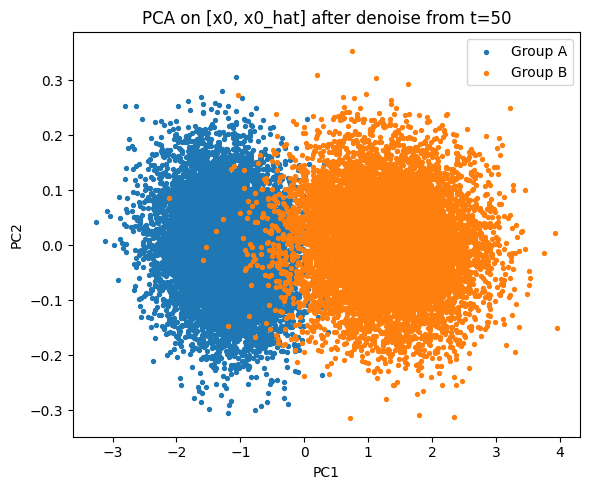

In [6]:
# ===== Imports（與你現有相容）=====
import torch, numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# ===== 1) 生成兩群常態資料（可改參數）=====
def make_two_normals(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, device='cpu', seed=42):
    g = torch.Generator(device=device).manual_seed(seed)
    x1 = torch.randn((n_each, 1), generator=g, device=device) * (var1**0.5) + mu1
    x2 = torch.randn((n_each, 1), generator=g, device=device) * (var2**0.5) + mu2
    return x1, x2

# ===== 2) 前向擴散（加噪）=====
@torch.no_grad()
def forward_diffuse(x0, t):
    """
    x0: (N,1), t: int 或 長度為 N 的 LongTensor (1..T)
    回傳 x_t 與當次用到的 eps（僅診斷用）
    """
    if not torch.is_tensor(t):
        t = torch.full((x0.shape[0],), int(t), device=x0.device, dtype=torch.long)
    eps = torch.randn_like(x0)
    x_t = sqrt_abar[t].unsqueeze(1) * x0 + sqrt_lmabar[t].unsqueeze(1) * eps
    return x_t, eps

# ===== 3) 反向擴散（Algorithm 2）=====
@torch.no_grad()
def denoise_from_t(model, x_t, t_start):
    """
    用訓練好的 model，從 t_start 一路 denoise 到 0
    （DDPM 更新式；與你訓練時常數表一致）
    """
    model.eval()
    n = x_t.shape[0]
    for t in range(int(t_start), 0, -1):
        tt = torch.full((n,), t, device=x_t.device, dtype=torch.long)
        eps_hat = model(x_t, tt)

        a_t    = alphas[t]      # α_t
        abar_t = abar[t]        # \bar α_t
        beta_t = betas[t]
        abar_tm1 = abar[t-1] if t > 1 else torch.tensor(1.0, device=x_t.device)

        # posterior 變異數 & 均值（經典 DDPM）
        beta_tilde = (1 - abar_tm1) / (1 - abar_t) * beta_t
        mean = (1.0/torch.sqrt(a_t)) * (x_t - (beta_t/torch.sqrt(1-abar_t)) * eps_hat)

        if t > 1:
            x_t = mean + torch.sqrt(beta_tilde) * torch.randn_like(x_t)
        else:
            x_t = mean
    return x_t  # 近似 \hat x_0

# ===== 4) 視覺化工具（直方圖 + ECDF）=====
def _to_np(x):
    try:
        if isinstance(x, torch.Tensor):
            return x.detach().flatten().cpu().numpy()
    except Exception:
        pass
    return np.asarray(x).ravel()

def ecdf_np(a):
    s = np.sort(a)
    n = s.size
    return s, np.arange(1, n+1)/n

def plot_two_dist(a, b, title="A vs B", bins=100):
    A = _to_np(a); B = _to_np(b)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    # 直方圖（密度）
    ax[0].hist(A, bins=bins, density=True, alpha=0.5, label="A")
    ax[0].hist(B, bins=bins, density=True, alpha=0.5, label="B")
    ax[0].set_title("Histogram (density)"); ax[0].set_xlabel("value"); ax[0].set_ylabel("density"); ax[0].legend()

    # ECDF
    xA, FA = ecdf_np(A); xB, FB = ecdf_np(B)
    ax[1].step(xA, FA, where="post", label="A")
    ax[1].step(xB, FB, where="post", label="B")
    ax[1].set_title("Empirical CDF"); ax[1].set_xlabel("value"); ax[1].set_ylabel("empirical CDF"); ax[1].legend()

    fig.suptitle(title); fig.tight_layout(); plt.show()

# ===== 5) 檢定小工具 =====
def tests_summary(a, b, title=""):
    A = _to_np(a); B = _to_np(b)
    ks = stats.ks_2samp(A, B)
    tt = stats.ttest_ind(A, B, equal_var=False)
    lv = stats.levene(A, B)
    print(f"\n=== {title} ===")
    print(f"mean: {A.mean():.3f} vs {B.mean():.3f}")
    print(f"std : {A.std(ddof=1):.3f} vs {B.std(ddof=1):.3f}")
    print(f"KS   : stat={ks.statistic:.4f}, p={ks.pvalue:.4f}")
    print(f"t-test(means): stat={tt.statistic:.4f}, p={tt.pvalue:.4f}")
    print(f"Levene(vars) : stat={lv.statistic:.4f}, p={lv.pvalue:.4f}")

# ===== 6) PCA 可視化：用 [x0, x0_hat] 作為 2D 特徵 =====
def pca_plot(x0_A, x0hat_A, x0_B, x0hat_B, title="PCA on [x0, x0_hat]"):
    A = np.stack([_to_np(x0_A), _to_np(x0hat_A)], axis=1)
    B = np.stack([_to_np(x0_B), _to_np(x0hat_B)], axis=1)
    X = np.vstack([A, B])
    y = np.array([0]*len(A) + [1]*len(B))  # 0: A, 1: B

    Xs = StandardScaler().fit_transform(X)
    Z  = PCA(n_components=2, random_state=0).fit_transform(Xs)

    plt.figure(figsize=(6,5))
    plt.scatter(Z[y==0,0], Z[y==0,1], s=8, label="Group A")
    plt.scatter(Z[y==1,0], Z[y==1,1], s=8, label="Group B")
    plt.title(title); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(); plt.tight_layout(); plt.show()

# ===== 7) 實驗主流程（一次跑完）=====
def run_two_normal_experiment(n_each=5000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, t_small=None):
    # 生成兩群
    xA0, xB0 = make_two_normals(n_each=n_each, mu1=mu1, var1=var1, mu2=mu2, var2=var2, device=DEVICE)

    # (A) 原始：應顯著不同
    tests_summary(xA0, xB0, "Original x0: A vs B")
    plot_two_dist(xA0, xB0, "Original x0 (two normals)")

    # (B) 從 T 去噪：常見會變「難分」（若無條件模型）
    xAT, _ = forward_diffuse(xA0, T)
    xBT, _ = forward_diffuse(xB0, T)
    xA_recon_full = denoise_from_t(model, xAT, T)
    xB_recon_full = denoise_from_t(model, xBT, T)
    tests_summary(xA_recon_full, xB_recon_full, "Denoise from T: A vs B")
    plot_two_dist(xA_recon_full, xB_recon_full, "Denoise from T")

    # PCA（看「原值 vs 去噪值」的分離度）
    pca_plot(xA0, xA_recon_full, xB0, xB_recon_full, title="PCA on [x0, x0_hat] after denoise from T")

    # (C) 從較小 t 去噪：應該較能保留差異
    if t_small is None:
        t_small = max(1, T//10)  # 例如 10% 的噪聲深度
    xAt, _ = forward_diffuse(xA0, t_small)
    xBt, _ = forward_diffuse(xB0, t_small)
    xA_recon_partial = denoise_from_t(model, xAt, t_small)
    xB_recon_partial = denoise_from_t(model, xBt, t_small)
    tests_summary(xA_recon_partial, xB_recon_partial, f"Denoise from t={t_small}: A vs B")
    plot_two_dist(xA_recon_partial, xB_recon_partial, f"Denoise from t={t_small}")

    # PCA（部分去噪）
    pca_plot(xA0, xA_recon_partial, xB0, xB_recon_partial, title=f"PCA on [x0, x0_hat] after denoise from t={t_small}")

import math

def sinusoidal_time_emb(t: torch.Tensor, dim: int, T: int = None, max_period: float = 10000.0):

    if T is not None:
        x = t.float() / float(T)     # 0~1 規模，訓練更穩
    else:
        x = t.float()

    half = dim // 2
    # 產生等比頻率：exp(-log(max_period) * k/half)
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(half, device=t.device).float() / half
    )  # (half,)

    # 相位 = 2π * x * freqs
    angles = 2.0 * math.pi * x.unsqueeze(1) * freqs.unsqueeze(0)  # (B, half)

    emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=1)  # (B, 2*half)
    if emb.shape[1] < dim:  # 若 dim 為奇數，補一維 0
        emb = torch.nn.functional.pad(emb, (0, 1))
    return emb

import torch, torch.nn as nn
# 假設你有 sinusoidal_time_emb(...)、EpsMLP(...) 之類；若名稱不同就改成你的
class EpsMLP(nn.Module):
    def __init__(self, hidden=HIDDEN, time_dim=TIME_DIM):
        super().__init__()
        self.time_dim = time_dim
        self.t_proj = nn.Sequential(nn.Linear(time_dim, hidden), nn.SiLU())
        self.net = nn.Sequential(
            nn.Linear(hidden + 1, hidden), nn.SiLU(),
            nn.Linear(hidden, hidden), nn.SiLU(),
            nn.Linear(hidden, 1)
        )
    def forward(self, x_t, t):
        t_emb = sinusoidal_time_emb(t, self.time_dim)   # 你原本的時間嵌入函式
        h_t  = self.t_proj(t_emb)
        h    = torch.cat([x_t, h_t], dim=1)
        return self.net(h)

# 2) 建立模型與優化器（跟你訓練時一致）
model = EpsMLP(hidden=HIDDEN, time_dim=TIME_DIM).to(DEVICE)
opt   = torch.optim.AdamW(model.parameters(), lr=5e-4)  # 或你實際用的參數



# ===== 8) 執行（可改參數）=====
# 例：各 10000 點，N(0,1) vs N(5,2)，小 t = T//10
run_two_normal_experiment(n_each=10000, mu1=0.0, var1=1.0, mu2=5.0, var2=2.0, t_small=T//10)
